In [58]:
# Загружаем картинки
from os import listdir, walk
from os.path import isfile, join
def take_all_pictures_names(path):
    paths = []
    targets = []
    for x in walk(path):
        print(x[0])
        for y in x[2]:
            paths.append(x[0] + '/' + y)
            targets.append(x[0][len(x[0]) - 1:])
    return paths, targets

def get_all_pictures(path, count=-1):
    names, targets = take_all_pictures_names(path)
    X = []
    for name in names:
        X.append(plt.imread(name))
        if (len(X) == count):
            break
    return X, targets

def show_picture(number):
    print(y[number], X[number].shape)
    plt.imshow(X[number])

In [42]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.datasets import mnist
%matplotlib inline

In [45]:
%time X, y = get_all_pictures('/media/ilya/DATA/sign_recognition_data/dataset5/', 5000)

/media/ilya/DATA/sign_recognition_data/dataset5/
/media/ilya/DATA/sign_recognition_data/dataset5/A
/media/ilya/DATA/sign_recognition_data/dataset5/A/a
/media/ilya/DATA/sign_recognition_data/dataset5/A/b
/media/ilya/DATA/sign_recognition_data/dataset5/A/c
/media/ilya/DATA/sign_recognition_data/dataset5/A/d
/media/ilya/DATA/sign_recognition_data/dataset5/A/e
/media/ilya/DATA/sign_recognition_data/dataset5/A/f
/media/ilya/DATA/sign_recognition_data/dataset5/A/g
/media/ilya/DATA/sign_recognition_data/dataset5/A/h
/media/ilya/DATA/sign_recognition_data/dataset5/A/i
/media/ilya/DATA/sign_recognition_data/dataset5/A/k
/media/ilya/DATA/sign_recognition_data/dataset5/A/l
/media/ilya/DATA/sign_recognition_data/dataset5/A/m
/media/ilya/DATA/sign_recognition_data/dataset5/A/n
/media/ilya/DATA/sign_recognition_data/dataset5/A/o
/media/ilya/DATA/sign_recognition_data/dataset5/A/p
/media/ilya/DATA/sign_recognition_data/dataset5/A/q
/media/ilya/DATA/sign_recognition_data/dataset5/A/r
/media/ilya/DATA/

e (127, 75, 3)


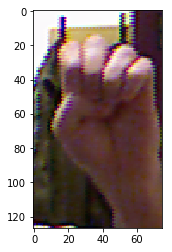

In [57]:
show_picture(4300)